# Generate signals, define plotters, set basic parameters

In [1]:
import numpy as np
import nengo
from nengolib.signal import s, z
from nengo.utils.numpy import rmse
import matplotlib.pyplot as plt
import seaborn as sns
from pathos import multiprocessing as mp
from nengolib.signal import LinearSystem
import nengolib
import copy
from bioneuron_oracle import BahlNeuron
from nengo.utils.matplotlib import rasterplot
%matplotlib inline

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def get_signals(
    signal_type,
    network_seed=1,
    sim_seed=1,
    sin_freq=1,
    signal_seed=1,
    t_final=1.0,
    white_noise_freq_cutoff=1,
    rms=1,
    tau=0.1,
    dt=0.001,
    t_transient=0.0):
        
    with nengo.Network(seed=network_seed) as network:
        def square(x):
            return x[0] * x[0]
        if signal_type == 'sin':
            stim = nengo.Node(lambda t: 
                np.sin(sin_freq * (t)))
        elif signal_type == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=t_final, high=white_noise_freq_cutoff, rms=rms, seed=signal_seed, y0=0))
        delayed_stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        sqr = nengo.Node(size_in=1)
        integ = nengo.Node(size_in=1)
        nengo.Connection(stim, delayed_stim,
            synapse=nengolib.synapses.DiscreteDelay(int(t_transient/dt)))
        nengo.Connection(delayed_stim, sqr, function=square)
        nengo.Connection(delayed_stim, integ, synapse=1/s)
        p_stim = nengo.Probe(delayed_stim, synapse=None)
        p_sqr = nengo.Probe(sqr, synapse=None)
        p_integ = nengo.Probe(integ, synapse=None)
        p_stim_filtered = nengo.Probe(delayed_stim, synapse=tau)
        p_sqr_filtered = nengo.Probe(sqr, synapse=tau)
    with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
        sim.run(t_transient + t_final + dt)
    stimulus = sim.data[p_stim]
    stimulus_filtered = sim.data[p_stim_filtered]
    square = sim.data[p_sqr]
    square_filtered = sim.data[p_sqr_filtered]
    integral = sim.data[p_integ]
    norm_stimulus = np.max(np.abs(stimulus_filtered))
    norm_square = np.max(np.abs(square_filtered))
    norm_integral = np.max(np.abs(integral))

    return stimulus, square, integral, norm_stimulus, norm_square, norm_integral

In [3]:
def run_plot(network, t_test, dt, sim_seed, t_plot=None):
    
    if t_plot==None:
        t_plot=t_test
        
    palette = sns.hls_palette(9, h=.6, l=.3, s=.9)
    colors = ["blue", "red", "green", "yellow", "purple", "orange", "cyan", "hot pink", "tan"]
    palette = sns.xkcd_palette(colors)
    sns.set(context='poster', palette=palette, style='white')
    alpha_bio = 1.0
    alpha_lif = 1.0
    alpha_target = 1.0

    with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
        sim.run(t_test)
    
    times = sim.trange()
    stim = sim.data[network.probe_stim]
    spikes_bio = sim.data[network.probe_bio_spikes]
    spikes_lif = sim.data[network.probe_lif_spikes]
    xhat_pre = sim.data[network.probe_pre]
    xhat_bio = sim.data[network.probe_bio]
    xhat_lif = sim.data[network.probe_lif]
    target = sim.data[network.probe_target]
    rmse_bio = rmse(xhat_bio, target)
    rmse_lif = rmse(xhat_lif, target)

    fig, ax = plt.subplots(1,1, figsize=(8,8))
#     ax.plot(times, stim, label='stim')
#     ax.plot(times, xhat_pre, label='pre')
    ax.plot(times, xhat_bio, alpha=alpha_bio, label='bio, rmse=%.5f' % rmse_bio)
    ax.plot(times, xhat_lif, alpha=alpha_lif, label='lif, rmse=%.5f' % rmse_lif)
    ax.plot(times, target, alpha=alpha_target, label='target')
    ax.set(ylim=((-1.0, 1.0)), xlim=((0.0, t_plot)), xlabel='time (s)', ylabel='$\hat{x}(t)$')
    ax.legend()
    plt.show()
    
    results_dict = {
        'times':times,
        'stim':stim,
        'spikes_bio': spikes_bio,
        'spikes_lif': spikes_lif,
        'xhat_bio':xhat_bio,
        'xhat_lif':xhat_lif,
        'target':target,
        'rmse_bio':rmse_bio,
        'rmse_lif':rmse_lif,
    }
    
    return results_dict

In [4]:
def build_filter(zeros, poles):
    """ create the transfer function from the passed constants to serve as the filter """
    built_filter = LinearSystem((zeros, poles, 1.0))
    built_filter /= built_filter.dcgain
    return built_filter

# Representation (feedforward communication channel)

In [5]:
def make_representation_network(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    stim_scale=1.0,
    bio_type=nengo.LIF(),
    signal=[],
    d_feedforward=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(0.1)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        target = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)

        ff_solver = nengo.solvers.NoSolver(d_feedforward)

        stim_pre = nengo.Connection(stim, pre,
            transform=stim_scale,
            synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            weights_bias_conn=True,
            seed=conn_seed,
            synapse=tau)
        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            seed=conn_seed)

        stim_target = nengo.Connection(stim, target,
            synapse=tau,  
            transform=stim_scale)

        lif_temp = nengo.Connection(lif, temp, synapse=tau)

        probe_pre_spikes = nengo.Probe(pre.neurons, 'spikes')
        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_spikes = nengo.Probe(lif.neurons, 'spikes')
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_target = nengo.Probe(target, synapse=tau)
        probe_stim = nengo.Probe(stim, synapse=None)
        probe_pre = nengo.Probe(pre, synapse=tau)

    network.lif_temp = lif_temp
    network.stim_pre = stim_pre
    network.pre_bio = pre_bio
    network.pre_lif = pre_lif
    network.stim_target = stim_target
    network.stim = stim
    network.bio = bio
    network.probe_pre_spikes = probe_pre_spikes
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_lif_spikes = probe_lif_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_lif_activity = probe_lif_activity
    network.probe_target = probe_target
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_pre = probe_pre
    network.probe_stim = probe_stim

    return network

Train on whitenoise, test on sin(t)

In [6]:
tau = 0.1
dt = 0.001
reg = 0.1
H_s = build_filter([-41.8],[-26.8, -8.9])  # poles and zeros from previous evolution
# H_s = nengo.Lowpass(tau)

pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
bio_type = BahlNeuron()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # 

white_noise_freq_cutoff = 5
rms = 0.5
t_train = 10.0
t_test = 5.0
signal_type_train = 'sin'
signal_type_test = 'sin'
seed_train = 1
seed_test = 2
sin_freq_train = 1
sin_freq_test = 2

stimulus_train, _, _, norm_stimulus_train, _, _ = get_signals(
    signal_type_train,
    network_seed,
    sim_seed,
    sin_freq_train,
    seed_train,
    t_train,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)
stimulus_test, _, _, norm_stimulus_test, _, _ = get_signals(
    signal_type_test,
    network_seed,
    sim_seed,
    sin_freq_test,
    seed_test,
    t_test,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)

/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1.], den=[1], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[ 0.]], B=[[ 0.]], C=[[ 0.]], D=[[ 1.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


Train feedforward decoders on sin(t)

In [7]:
network = make_representation_network(
    tau=tau,
    stim_scale=1.0/norm_stimulus_train,
    bio_type=bio_type,
    signal=stimulus_train,
    d_feedforward=np.zeros((100, 1)),
    H_ff=H_s)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_train)

act_bio = sim.data[network.probe_bio_activity]
target = sim.data[network.probe_target]
d_ff = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:09:33.                                                 


Test on sinusoid on sin(2t)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:11:57.                                                 


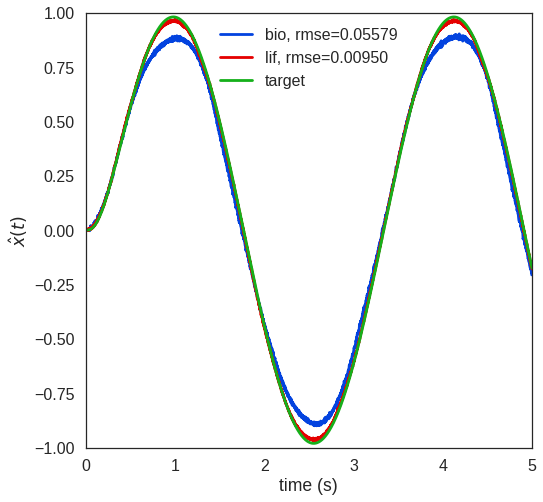

In [8]:
network = make_representation_network(
    tau=tau,
    stim_scale=1.0/norm_stimulus_test,
    bio_type=bio_type,
    signal=stimulus_test,
    d_feedforward=d_ff,
    H_ff=H_s)

representation_dict = run_plot(network, t_test, dt, sim_seed)
representation_dict['d_ff'] = d_ff

### Generate spike rasters and state-space plots for Figure 1

In [9]:
network = make_representation_network(
    tau=tau,
    stim_scale=1.0/norm_stimulus_test,
    bio_type=bio_type,
    signal=stimulus_test,
    d_feedforward=d_ff,
    H_ff=H_s)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_test)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:06:19.                                                 


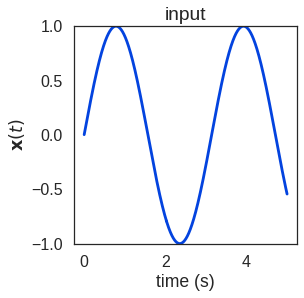

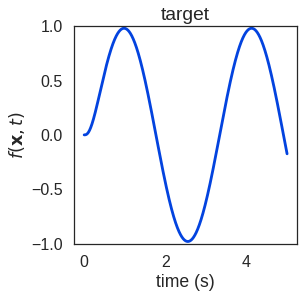

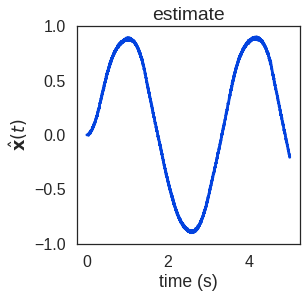

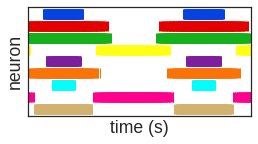

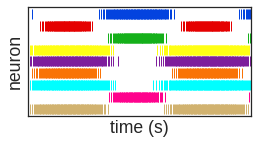

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(sim.trange(), sim.data[network.probe_stim])
ax.set(xlabel='time (s)', ylabel='$\mathbf{x}(t)$', title='input', ylim=((-1,1)))

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(sim.trange(), sim.data[network.probe_target])
ax.set(xlabel='time (s)', ylabel='$f(\mathbf{x},t)$', title='target', ylim=((-1,1)))

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(sim.trange(), sim.data[network.probe_bio])
ax.set(xlabel='time (s)', ylabel='$\hat{\mathbf{x}}(t)$', title='estimate', ylim=((-1,1)))

from nengo.utils.matplotlib import rasterplot

fig, ax = plt.subplots(1, 1, figsize=(4,2))
rasterplot(sim.trange(), sim.data[network.probe_pre_spikes][:,:9])
plt.xticks([])
plt.yticks([])
ax.set(xlabel='time (s)', ylabel='neuron')


fig, ax = plt.subplots(1, 1, figsize=(4,2))
rasterplot(sim.trange(), sim.data[network.probe_bio_spikes][:,:9])
plt.xticks([])
plt.yticks([])
ax.set(xlabel='time (s)', ylabel='neuron')

plt.show()

In [11]:
np.save('jupyter_data/representation_dict.npy', representation_dict)

# Computation (feedforward square)

In [12]:
def make_computation_network(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    stim_scale=1.0,
    square_scale=1.0,
    bio_type=nengo.LIF(),
    signal=[],
    square=[],
    d_feedforward=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(0.1)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        def f_square(x):
            return x[0] * x[0]
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        sqr = nengo.Node(lambda t: square[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        target = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)

        ff_solver = nengo.solvers.NoSolver(d_feedforward)

        stim_pre = nengo.Connection(stim, pre,
            transform=stim_scale,
            synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            weights_bias_conn=True,
            seed=conn_seed,
            synapse=tau)
        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            seed=conn_seed,
            function=f_square)

        square_target = nengo.Connection(sqr, target,
            synapse=tau,  
            transform=square_scale)

        lif_temp = nengo.Connection(lif, temp, synapse=tau)

        probe_pre_spikes = nengo.Probe(pre.neurons, 'spikes')
        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_spikes = nengo.Probe(lif.neurons, 'spikes')
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_target = nengo.Probe(target, synapse=tau)
        probe_stim = nengo.Probe(stim, synapse=None)
        probe_pre = nengo.Probe(pre, synapse=tau)

    network.lif_temp = lif_temp
    network.stim_pre = stim_pre
    network.pre_bio = pre_bio
    network.pre_lif = pre_lif
    network.square_target = square_target
    network.stim = stim
    network.bio = bio
    network.probe_pre_spikes = probe_pre_spikes
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_lif_spikes = probe_lif_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_lif_activity = probe_lif_activity
    network.probe_target = probe_target
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_pre = probe_pre
    network.probe_stim = probe_stim

    return network

In [13]:
tau = 0.1
dt = 0.001
reg = 0.1
H_s = build_filter([-41.8],[-26.8, -8.9])  # poles and zeros from previous evolution
# H_s = nengo.Lowpass(tau)

pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
bio_type = BahlNeuron()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # 

white_noise_freq_cutoff = 5
rms = 0.5
t_train = 10.0
t_test = 5.0
signal_type_train = 'sin'
signal_type_test = 'sin'
seed_train = 1
seed_test = 2
sin_freq_train = 1
sin_freq_test = 2

stimulus_train, square_train, _, norm_stimulus_train, norm_square_train, _ = get_signals(
    signal_type_train,
    network_seed,
    sim_seed,
    sin_freq_train,
    seed_train,
    t_train,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)
stimulus_test, square_test, _, norm_stimulus_test, norm_square_test, _ = get_signals(
    signal_type_test,
    network_seed,
    sim_seed,
    sin_freq_test,
    seed_test,
    t_test,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)

Train feedforward decoders to compute the square of the input signal

In [14]:
network = make_computation_network(
    tau=tau,
    stim_scale=1.0/norm_stimulus_train,
    square_scale=1.0,
    bio_type=bio_type,
    signal=stimulus_train,
    square=square_train,
    d_feedforward=np.zeros((100, 1)),
    H_ff=H_s)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_train)

act_bio = sim.data[network.probe_bio_activity]
target = sim.data[network.probe_target]
d_ff = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:10:04.                                                 


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:14:25.                                                 


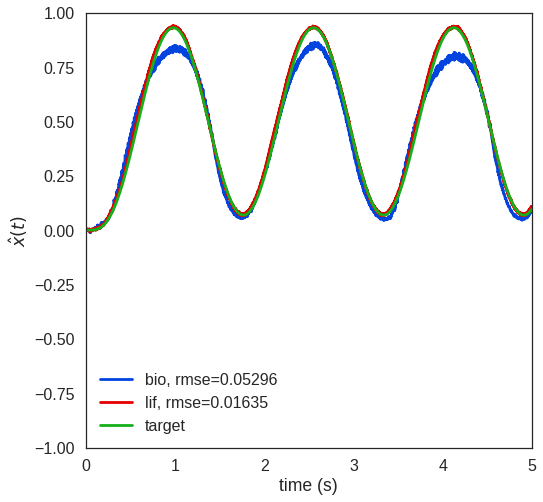

In [15]:
network = make_computation_network(
    tau=tau,
    stim_scale=1.0/norm_stimulus_test,
    square_scale=1.0,
    bio_type=bio_type,
    signal=stimulus_test,
    square=square_test,
    d_feedforward=d_ff,
    H_ff=H_s)

computation_dict = run_plot(network, t_test, dt, sim_seed)
computation_dict['d_ff'] = d_ff

### Generate spike rasters and state-space plots for Figure 1

In [16]:
# network = make_computation_network(
#     tau=tau,
#     stim_scale=1.0/norm_stimulus_test,
#     square_scale=1.0,
#     bio_type=bio_type,
#     signal=stimulus_test,
#     square=square_test,
#     d_feedforward=d_ff,
#     H_ff=H_s)

# with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
#     sim.run(t_test)

In [17]:
# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# ax.plot(sim.trange(), sim.data[network.probe_stim])
# ax.set(xlabel='time (s)', ylabel='$\mathbf{x}(t)$', title='input', ylim=((-1,1)))

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# ax.plot(sim.trange(), sim.data[network.probe_target])
# ax.set(xlabel='time (s)', ylabel='$f(\mathbf{x},t)$', title='target', ylim=((-1,1)))

# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# ax.plot(sim.trange(), sim.data[network.probe_bio])
# ax.set(xlabel='time (s)', ylabel='$f(\mathbf{x},t)$', title='estimate', ylim=((-1,1)))

# from nengo.utils.matplotlib import rasterplot

# fig, ax = plt.subplots(1, 1, figsize=(4,2))
# rasterplot(sim.trange(), sim.data[network.probe_pre_spikes][:,:9])
# plt.xticks([])
# plt.yticks([])
# ax.set(xlabel='time (s)', ylabel='neuron')


# fig, ax = plt.subplots(1, 1, figsize=(4,2))
# rasterplot(sim.trange(), sim.data[network.probe_bio_spikes][:,:9])
# plt.xticks([])
# plt.yticks([])
# ax.set(xlabel='time (s)', ylabel='neuron')

# plt.show()

In [18]:
np.save('jupyter_data/computation_dict.npy', computation_dict)

# Dynamics (feedback integrator)

In [19]:
def make_dynamics_network(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    post_seed=6,
    inter_seed=7,
    conn2_seed=9,
    conn3_seed=10,
    bio_type=nengo.LIF(),
    inter_type=nengo.LIF(),
    signal=[],
    integral=[],
    T_stim_pre=1.0,
    T_pre_lifbio=1.0,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=0.0,
    T_lif_lif=0.0,
    T_stim_target=1.0,
    T_integ_target=0.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100,1)),
    d_inter=np.zeros((100,1)),
    H_ff=nengo.Lowpass(0.1)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        integ = nengo.Node(lambda t: integral[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=T_stim_pre*np.max(np.abs(signal)),  # ensures no saturation
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        inter = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=inter_type,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            label='inter')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        target = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)

        ff_solver = nengo.solvers.NoSolver(d_feedforward)
        fb_solver = nengo.solvers.NoSolver(d_feedback)
        inter_solver = nengo.solvers.NoSolver(d_inter)

        stim_pre = nengo.Connection(stim, pre,
            transform=T_stim_pre,
            synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            weights_bias_conn=True,
            seed=conn_seed,
            synapse=tau,
            transform=T_pre_lifbio)
        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            seed=conn_seed,
            transform=T_pre_lifbio)
        
        bio_bio = nengo.Connection(bio, bio,
            seed=conn2_seed,
            synapse=tau,
            solver=fb_solver,
            transform=T_bio_bio)        
        nengo.Connection(lif, lif,
            seed=conn2_seed,
            synapse=tau,
            transform=T_lif_lif)

        stim_target = nengo.Connection(stim, target,
            synapse=tau,  
            transform=T_stim_target)  # only nonzero for ff pass
        integ_target = nengo.Connection(integ, target,
            synapse=None,  
            transform=T_integ_target)

        integ_inter = nengo.Connection(integ, inter,
            seed=conn3_seed,
            synapse=None,
            transform=T_integ_inter)
        nengo.Connection(inter, bio,
            seed=conn3_seed,
            synapse=tau,
            transform=T_inter_bio,  # only connect training spikes when != 0
            solver=inter_solver)  

        lif_out = nengo.Connection(lif, temp, synapse=tau)

        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_spikes = nengo.Probe(lif.neurons, 'spikes')
        probe_inter_spikes = nengo.Probe(inter.neurons, 'spikes', synapse=None)
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_inter_activity = nengo.Probe(inter.neurons, 'spikes', synapse=tau)
        probe_target = nengo.Probe(target, synapse=H_ff)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_inter = nengo.Probe(inter, synapse=tau, solver=inter_solver)
        probe_pre = nengo.Probe(pre, synapse=tau)
        probe_stim = nengo.Probe(stim, synapse=None)
        probe_integ = nengo.Probe(integ, synapse=tau)  # TODO: make sure unfiltered not needed

#     network.bio = bio
    network.lif_out = lif_out
#     network.bio_bio = bio_bio
#     network.stim = stim
#     network.integ = integ
#     network.stim_pre = stim_pre
#     network.pre_bio = pre_bio
#     network.pre_lif = pre_lif
#     network.stim_target = stim_target
#     network.integ_target = integ_target
#     network.integ_inter = integ_inter
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_lif_spikes = probe_lif_spikes
    network.probe_inter_spikes = probe_inter_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_lif_activity = probe_lif_activity
    network.probe_inter_activity = probe_inter_activity
    network.probe_stim = probe_stim
    network.probe_integ = probe_integ
    network.probe_target = probe_target
    network.probe_pre = probe_pre
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_inter = probe_inter

    return network

## Train white_noise, test white_noise

In [20]:
tau = 0.1
dt = 0.001
reg = 0.1
# H_s = build_filter([-41.8],[-26.8, -8.9])  # poles and zeros from previous evolution
H_s = nengo.Lowpass(tau)  # NOTE: back to normal Lowpass filter for integrator

pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
bio_type = BahlNeuron()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # 
inter_type = nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # BahlNeuron()  # 

white_noise_freq_cutoff = 5
rms = 0.5
t_transient = 0.0
t_train = 10.0
t_test = 5.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2
sin_freq_train = 1
sin_freq_test = 2

stimulus_train, _, integral_train, norm_stimulus_train, _, norm_integ_train = get_signals(
    signal_type_train,
    network_seed,
    sim_seed,
    sin_freq_train,
    seed_train,
    t_train,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)
stimulus_test, _, integral_test, norm_stimulus_test, _, norm_integ_test = get_signals(
    signal_type_test,
    network_seed,
    sim_seed,
    sin_freq_test,
    seed_test,
    t_test,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt)

In [21]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_integ_train,
    T_pre_lifbio=1.0,
    T_integ_inter=1.0/norm_integ_train,
    T_inter_bio=0.0,
    T_bio_bio=0.0,
    T_lif_lif=0.0,
    T_stim_target=1.0/norm_integ_train,
    T_integ_target=0.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100, 1)),
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_train)
    
act_bio = sim.data[network.probe_bio_activity]
act_inter = sim.data[network.probe_inter_activity]
target = sim.data[network.probe_target]
integral = sim.data[network.probe_integ]
d_feedforward_eval_points = sim.data[network.lif_out].weights.T
d_ff = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_target = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral/norm_integ_train)[0]

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_integ_train,
    T_pre_lifbio=tau,
    T_integ_inter=1.0/norm_integ_train,
    T_inter_bio=1.0,
    T_bio_bio=0.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_train,
    d_feedforward=d_ff,
    d_feedback=np.zeros((100, 1)),
    d_inter=d_inter_target,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_train)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_target][int(t_transient/dt):]
d_fb = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:20:57.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:21:00.                                                 


In [22]:
# rmse_bio = rmse(target, np.dot(act_bio, d_fb))
# fig, ax,  = plt.subplots(1, 1, figsize=(8,4))
# ax.plot(sim.trange(), target)
# ax.plot(sim.trange(), np.dot(act_bio, d_fb), label='rmse_bio = %.5f' % rmse_bio)
# ax.set(xlabel='time (s)', ylabel='f(x,t) w/ inter spikes')
# ax.legend()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,16))
# rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax1)
# rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax2)
# plt.xticks([])
# plt.yticks([])
# ax2.set(xlabel='time (s)', ylabel='neuron')

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:24:01.                                                 


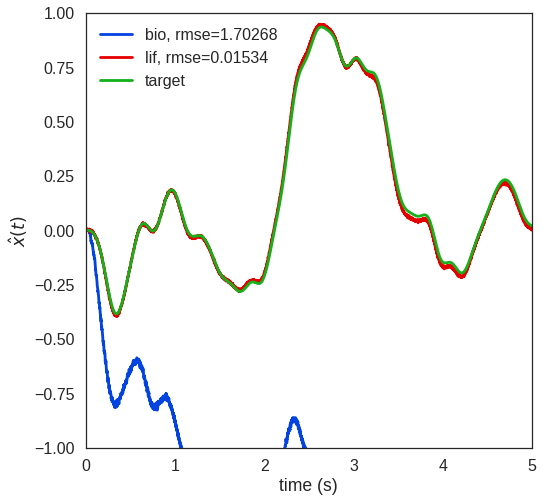

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:24:16.                                                 


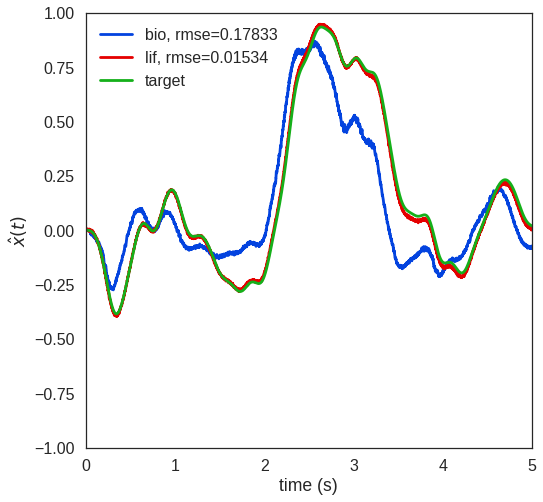

In [23]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_ff,
    d_feedback=d_ff,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_white_noise_ff = run_plot(network, t_test, dt, sim_seed)
dynamics_dict_white_noise_ff['d_ff'] = d_ff
dynamics_dict_white_noise_ff['d_fb'] = d_fb

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_fb,
    d_feedback=d_fb,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_white_noise_fb = run_plot(network, t_test, dt, sim_seed)
dynamics_dict_white_noise_fb['d_ff'] = d_ff
dynamics_dict_white_noise_fb['d_fb'] = d_fb

In [24]:
# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# sns.kdeplot(d_ff.squeeze(), ax=ax)
# sns.kdeplot(d_fb.squeeze(), ax=ax)
# ax.set(xlabel='decoder value', ylabel='KDE')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,16))
# rasterplot(dynamics_dict_white_noise_fb['times'], dynamics_dict_white_noise_fb['spikes_bio'], ax=ax1)
# rasterplot(dynamics_dict_white_noise_fb['times'], dynamics_dict_white_noise_fb['spikes_lif'], ax=ax2)
# ax2.set(xlabel='time (s)', ylabel='neuron')

In [25]:
np.save('jupyter_data/dynamics_dict_white_noise_ff.npy', dynamics_dict_white_noise_ff)
np.save('jupyter_data/dynamics_dict_white_noise_fb.npy', dynamics_dict_white_noise_fb)

## Train sin(t), test white_noise

In [26]:
tau = 0.1
dt = 0.001
reg = 0.1
# H_s = build_filter([-41.8],[-26.8, -8.9])  # poles and zeros from previous evolution
H_s = nengo.Lowpass(tau)  # NOTE: back to normal Lowpass filter for integrator

pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
bio_type = BahlNeuron()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  #  
inter_type = nengo.LIF()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # BahlNeuron()  # 

white_noise_freq_cutoff = 5
rms = 0.5
t_transient = 0.0
t_train = 10.0
t_test = 5.0
signal_type_train = 'sin'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2
sin_freq_train = 1
sin_freq_test = 2

stimulus_train, _, integral_train, norm_stimulus_train, _, norm_integ_train = get_signals(
    signal_type_train,
    network_seed,
    sim_seed,
    sin_freq_train,
    seed_train,
    t_train,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt,
    t_transient)
stimulus_test, _, integral_test, norm_stimulus_test, _, norm_integ_test = get_signals(
    signal_type_test,
    network_seed,
    sim_seed,
    sin_freq_test,
    seed_test,
    t_test,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt,
    t_transient)

In [27]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_stimulus_train,
    T_pre_lifbio=1.0,
    T_integ_inter=1.0/norm_integ_train,  # only for d_inter
    T_inter_bio=0.0,
    T_bio_bio=0.0,
    T_lif_lif=0.0,
    T_stim_target=1.0/norm_stimulus_train,
    T_integ_target=0.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100, 1)),
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity]
act_inter = sim.data[network.probe_inter_activity]
target = sim.data[network.probe_target]
integral = sim.data[network.probe_integ]
d_feedforward_eval_points = sim.data[network.lif_out].weights.T
d_ff = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral/norm_integ_train)[0]

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_integ_train,
    T_pre_lifbio=tau,
    T_integ_inter=1.0/norm_integ_train,
    T_inter_bio=1.0,
    T_bio_bio=0.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_train,
    d_feedforward=d_ff,
    d_feedback=np.zeros((100, 1)),
    d_inter=d_inter,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity]
target = sim.data[network.probe_target]
d_fb = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:22:42.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:22:10.                                                 


In [28]:
# rmse_bio = rmse(target, np.dot(act_bio, d_fb))
# fig, ax,  = plt.subplots(1, 1, figsize=(8,4))
# ax.plot(sim.trange(), target)
# ax.plot(sim.trange(), np.dot(act_bio, d_fb), label='rmse_bio = %.5f' % rmse_bio)
# ax.set(xlabel='time (s)', ylabel='f(x,t) w/ inter spikes')
# ax.legend()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,16))
# rasterplot(sim.trange(), sim.data[network.probe_bio_spikes], ax=ax1)
# rasterplot(sim.trange(), sim.data[network.probe_lif_spikes], ax=ax2)
# plt.xticks([])
# plt.yticks([])
# ax2.set(xlabel='time (s)', ylabel='neuron')

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:25:42.                                                 


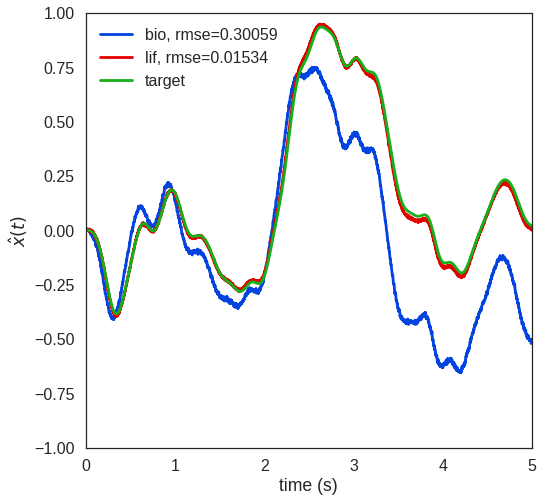

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:27:52.                                                 


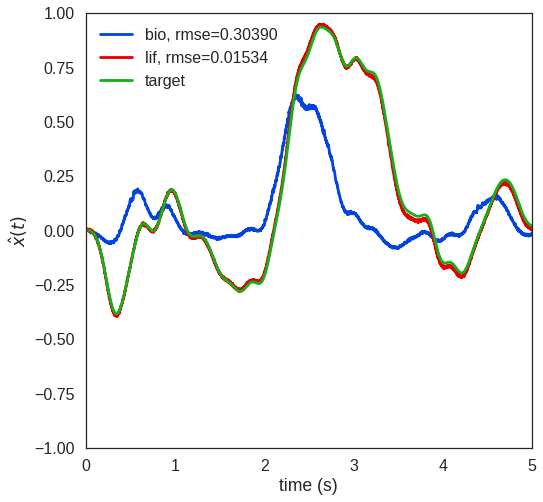

In [29]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_ff,
    d_feedback=d_ff,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_sin_white_noise_ff = run_plot(network, t_transient + t_test, dt, sim_seed)
dynamics_dict_sin_white_noise_ff['d_ff'] = d_ff
dynamics_dict_sin_white_noise_ff['d_fb'] = d_fb

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_fb,
    d_feedback=d_fb,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_sin_white_noise_fb = run_plot(network, t_transient + t_test, dt, sim_seed)
dynamics_dict_sin_white_noise_fb['d_ff'] = d_ff
dynamics_dict_sin_white_noise_fb['d_fb'] = d_fb

In [30]:
# fig, ax = plt.subplots(1, 1, figsize=(4,4))
# sns.kdeplot(d_ff.squeeze(), ax=ax)
# sns.kdeplot(d_fb.squeeze(), ax=ax)
# ax.set(xlabel='decoder value', ylabel='KDE')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,16))
# rasterplot(dynamics_dict_sin_white_noise_fb['times'], dynamics_dict_sin_white_noise_fb['spikes_bio'], ax=ax1)
# rasterplot(dynamics_dict_sin_white_noise_fb['times'], dynamics_dict_sin_white_noise_fb['spikes_lif'], ax=ax2)
# ax2.set(xlabel='time (s)', ylabel='neuron')

In [31]:
np.save('jupyter_data/dynamics_dict_sin_white_noise_ff.npy', dynamics_dict_sin_white_noise_ff)
np.save('jupyter_data/dynamics_dict_sin_white_noise_fb.npy', dynamics_dict_sin_white_noise_fb)

## Train sin(t), test sin(2t)

In [32]:
tau = 0.1
dt = 0.001
reg = 0.1
# H_s = build_filter([-41.8],[-26.8, -8.9])  # poles and zeros from previous evolution
H_s = nengo.Lowpass(tau)  # NOTE: back to normal Lowpass filter for integrator

pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
bio_type = BahlNeuron()  # nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  #  
inter_type = nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1)  # BahlNeuron()  # 

white_noise_freq_cutoff = 5
rms = 0.5
t_transient = 0.0
t_train = 10.0
t_test = 5.0
signal_type_train = 'sin'
signal_type_test = 'sin'
seed_train = 3
seed_test = 2
sin_freq_train = 1
sin_freq_test = 2

stimulus_train, _, integral_train, norm_stimulus_train, _, norm_integ_train = get_signals(
    signal_type_train,
    network_seed,
    sim_seed,
    sin_freq_train,
    seed_train,
    t_train,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt,
    t_transient)
stimulus_test, _, integral_test, norm_stimulus_test, _, norm_integ_test = get_signals(
    signal_type_test,
    network_seed,
    sim_seed,
    sin_freq_test,
    seed_test,
    t_test,
    white_noise_freq_cutoff,
    rms,
    tau,
    dt,
    t_transient)

In [33]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_stimulus_train,
    T_pre_lifbio=1.0,
    T_integ_inter=1.0/norm_integ_train,  # only for d_inter
    T_inter_bio=0.0,
    T_bio_bio=0.0,
    T_lif_lif=0.0,
    T_stim_target=1.0/norm_stimulus_train,
    T_integ_target=0.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100, 1)),
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity]
act_inter = sim.data[network.probe_inter_activity]
target = sim.data[network.probe_target]
integral = sim.data[network.probe_integ]
d_feedforward_eval_points = sim.data[network.lif_out].weights.T
d_ff = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral/norm_integ_train)[0]

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_train,
    integral=integral_train,
    T_stim_pre=1.0/norm_integ_train,
    T_pre_lifbio=tau,
    T_integ_inter=1.0/norm_integ_train,
    T_inter_bio=1.0,
    T_bio_bio=0.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_train,
    d_feedforward=d_ff,
    d_feedback=np.zeros((100, 1)),
    d_inter=d_inter,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)
    
act_bio = sim.data[network.probe_bio_activity]
target = sim.data[network.probe_target]
d_fb = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:02.                                                   
Simulating finished in 0:24:31.                                                 
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:23:01.                                                 


Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:25:38.                                                 


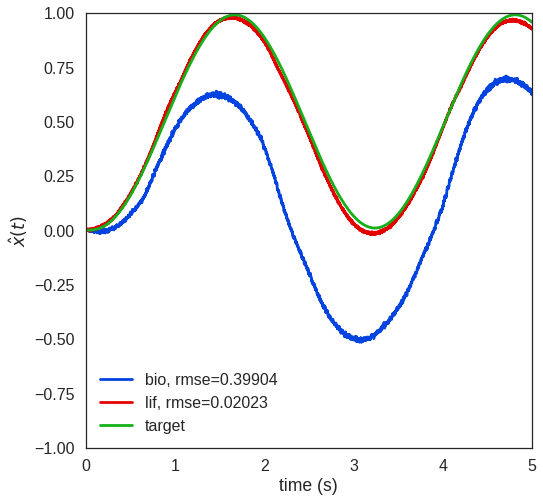

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:26:40.                                                 


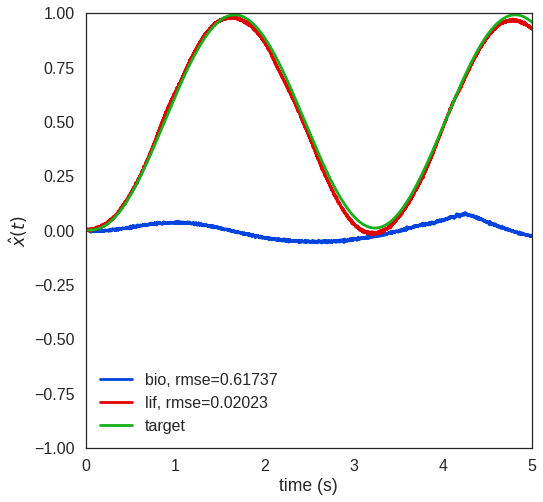

In [34]:
network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_ff,
    d_feedback=d_ff,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_sin_ff = run_plot(network, t_transient + t_test, dt, sim_seed)
dynamics_dict_sin_ff['d_ff'] = d_ff
dynamics_dict_sin_ff['d_fb'] = d_fb

network = make_dynamics_network(
    bio_type=bio_type,
    inter_type=inter_type,    
    signal=stimulus_test,
    integral=integral_test,
    T_stim_pre=1.0/norm_integ_test,
    T_pre_lifbio=tau,
    T_integ_inter=0.0,
    T_inter_bio=0.0,
    T_bio_bio=1.0,
    T_lif_lif=1.0,
    T_stim_target=0.0,
    T_integ_target=1.0/norm_integ_test,
    d_feedforward=d_fb,
    d_feedback=d_fb,
    d_inter=np.zeros((100, 1)),
    H_ff=nengo.Lowpass(tau)
)

dynamics_dict_sin_fb = run_plot(network, t_transient + t_test, dt, sim_seed)
dynamics_dict_sin_fb['d_ff'] = d_ff
dynamics_dict_sin_fb['d_fb'] = d_fb

In [35]:
np.save('jupyter_data/dynamics_dict_sin_ff.npy', dynamics_dict_sin_ff)
np.save('jupyter_data/dynamics_dict_sin_fb.npy', dynamics_dict_sin_fb)

# Plot Figure 2 of the Cosyne abstract

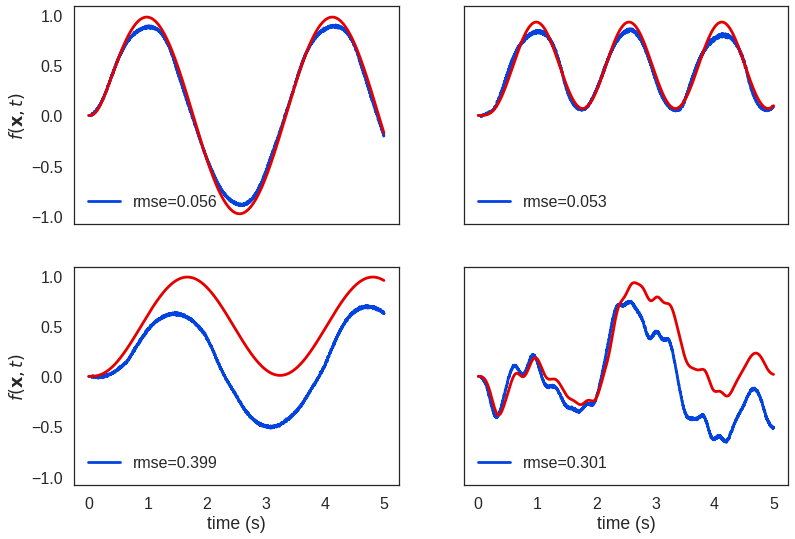

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

ax1.plot(representation_dict['times'], representation_dict['xhat_bio'],
         label='rmse=%.3f' % representation_dict['rmse_bio'])
ax1.plot(representation_dict['times'], representation_dict['target'])
ax1.legend(loc='lower left')

ax2.plot(computation_dict['times'], computation_dict['xhat_bio'],
         label='rmse=%.3f' % computation_dict['rmse_bio'])
ax2.plot(computation_dict['times'], computation_dict['target'])
ax2.legend(loc='lower left')

ax3.plot(dynamics_dict_sin_ff['times'], dynamics_dict_sin_ff['xhat_bio'],
         label='rmse=%.3f' % dynamics_dict_sin_ff['rmse_bio'])
ax3.plot(dynamics_dict_sin_ff['times'], dynamics_dict_sin_ff['target'])
ax3.legend(loc='lower left')

ax4.plot(dynamics_dict_sin_white_noise_ff['times'], dynamics_dict_sin_white_noise_ff['xhat_bio'],
         label='rmse=%.3f' % dynamics_dict_sin_white_noise_ff['rmse_bio'])
ax4.plot(dynamics_dict_sin_white_noise_ff['times'], dynamics_dict_sin_white_noise_ff['target'])
ax4.legend(loc='lower left')

ax1.set(ylabel='$f(\mathbf{x},t)$')
ax2.set()
ax3.set(xlabel='time (s)', ylabel='$f(\mathbf{x},t)$')
ax4.set(xlabel='time (s)')

plt.show()